# 🛒 Olist E-Commerce Customer & Fulfillment Analysis

This project explores the **Brazilian E-Commerce Public Dataset by Olist** to analyze seller performance, fulfillment reliability, and customer dynamics using SQL and Python.

## 🔍 Goals
- 🧠 Showcase SQL capabilities: joins, CTEs, window functions
- 📦 Investigate seller concentration (Pareto principle)
- 🚚 Analyze fulfillment performance and late deliveries
- 👥 Explore customer behavior through cohort analysis

Data was queried from a MySQL database using a custom SQL script (`prepare_seller_customer_order_data.sql`).

## 🧹 Data Preparation
- Most initial preparation was completed in SQL to create a unified, analysis-ready dataset by:
  - Joining multiple Olist tables (orders, customers, sellers, products, reviews, etc.)
  - Leveraging advanced SQL techniques including **CTEs** and **window functions**
  - Calculating key fields such as item-level revenue
  - Retaining multiple reviews per order while structuring the data to support **aggregation** and **deduplication** as needed
  - Including supporting fields (e.g., timestamps, geographic data) to enable downstream analysis
- The resulting dataset was then imported into Python from a MySQL database for further transformation and modeling.
- Additional preparation steps in this notebook include:
  - Parsing timestamps and calculating **delivery delays**
  - Handling **missing values** and interpreting them in context
  - Engineering new features such as **customer segments** and **anomaly flags**
  - Structuring the data for visualization and modeling

In [2]:
# import common librariies and some necessary ones
# access and read in the dataset from MySQL
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Provide credentials
username = 'root'
password = os.getenv('DB_PASSWORD')
host = 'localhost'
port = '3306'
database = 'olist_db'

# Connect to MySQL and load query
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")



with open('../sql/prepare_seller_customer_order_data.sql', 'r') as file:
    query = file.read()

# df = pd.read_sql_query(query, engine)
from sqlalchemy import text

with engine.connect() as connection:
    result = connection.execution_options(stream_results=True).execute(text(query))
    df = pd.DataFrame(result.fetchall(), columns=result.keys())



df.head()

/Users/joelam/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,...,cust_zip,cust_city,cust_state,seller_zip,s_city,s_state,order_total_revenue,avg_seller_review_score,cust_rank_by_seller_revenue,review_instance
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,...,28013,campos dos goytacazes,RJ,27277,volta redonda,SP,72.190001,4.0464,70,1
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,...,15775,santa fe do sul,SP,3471,sao paulo,SP,259.829994,3.7606,10,1
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,...,35661,para de minas,MG,37564,borda da mata,MG,216.870001,3.7857,8,1
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,...,12952,atibaia,SP,14403,franca,SP,25.780000,3.7500,9,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,...,13226,varzea paulista,SP,87900,loanda,PR,218.039993,3.7241,9,1


In [3]:
# Remove duplicates caused by multiple reviews
df = df[df['review_instance'] == 1]

### 🧼 Data Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98666 entries, 0 to 113313
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98666 non-null  object        
 1   customer_id                    98666 non-null  object        
 2   order_status                   98666 non-null  object        
 3   order_purchase_timestamp       98666 non-null  datetime64[ns]
 4   order_delivered_customer_date  96476 non-null  datetime64[ns]
 5   order_estimated_delivery_date  98666 non-null  datetime64[ns]
 6   product_id                     98666 non-null  object        
 7   seller_id                      98666 non-null  object        
 8   price                          98666 non-null  float64       
 9   freight_value                  98666 non-null  float64       
 10  item_revenue                   98666 non-null  float64       
 11  review_score       

In [5]:
# rename seller columns to be easier to understand and consistent
df = df.rename(columns={'s_city': 'seller_city', 
                   's_state': 'seller_state'})

In [6]:
# confirm column name changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98666 entries, 0 to 113313
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98666 non-null  object        
 1   customer_id                    98666 non-null  object        
 2   order_status                   98666 non-null  object        
 3   order_purchase_timestamp       98666 non-null  datetime64[ns]
 4   order_delivered_customer_date  96476 non-null  datetime64[ns]
 5   order_estimated_delivery_date  98666 non-null  datetime64[ns]
 6   product_id                     98666 non-null  object        
 7   seller_id                      98666 non-null  object        
 8   price                          98666 non-null  float64       
 9   freight_value                  98666 non-null  float64       
 10  item_revenue                   98666 non-null  float64       
 11  review_score       

In [7]:
# get familar wiht numeric columns
df.describe()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,price,freight_value,item_revenue,review_score,review_creation_date,order_total_revenue,cust_rank_by_seller_revenue,review_instance
count,98666,96476,98666,98666.000000,98666.000000,98666.000000,97917.000000,97917,98666.000000,98666.000000,98666.0
mean,2017-12-31 22:05:22.366560,2018-01-14 12:09:19.035542272,2018-01-24 16:36:25.409360896,125.940358,20.195033,146.135391,4.105600,2018-01-13 15:42:30.372253952,161.310607,99.037794,1.0
min,2016-09-04 21:15:19,2016-10-11 13:46:32,2016-10-04 00:00:00,0.850000,0.000000,9.090000,1.000000,2016-10-06 00:00:00,9.590000,1.000000,1.0
25%,2017-09-12 23:21:27.500000,2017-09-25 22:07:22.249999872,2017-10-04 00:00:00,41.500000,13.300000,57.370001,4.000000,2017-09-26 00:00:00,62.149998,14.000000,1.0
50%,2018-01-19 18:02:47,2018-02-02 19:28:10.500000,2018-02-15 00:00:00,79.000000,16.360000,96.120001,5.000000,2018-02-02 00:00:00,105.664999,45.000000,1.0
75%,2018-05-04 20:05:35.249999872,2018-05-15 22:48:52.249999872,2018-05-28 00:00:00,139.900000,21.240000,163.077496,5.000000,2018-05-16 00:00:00,177.489994,127.000000,1.0
max,2018-09-03 09:06:57,2018-10-17 13:22:46,2018-10-25 00:00:00,6735.000000,409.680000,6929.309998,5.000000,2018-08-31 00:00:00,13664.080002,813.000000,1.0
std,NaN,NaN,NaN,191.181524,15.871925,198.438371,1.331007,NaN,221.293039,130.815642,0.0


In [8]:
# Check for missing values
df.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_delivered_customer_date     2190
order_estimated_delivery_date        0
product_id                           0
seller_id                            0
price                                0
freight_value                        0
item_revenue                         0
review_score                       749
review_creation_date               749
review_comment_message           58399
product_category_name             1414
product_category_name_english     1436
category                          2884
cust_unique_id                       0
cust_zip                             0
cust_city                            0
cust_state                           0
seller_zip                           0
seller_city                          0
seller_state                         0
order_total_revenue                  0
avg_seller_review_score  

In [9]:
# Check status of orders with missing delivery date
missing_delivery = df[df['order_delivered_customer_date'].isna()]

# What order statuses do these rows have?
print(missing_delivery['order_status'].value_counts())

order_status
shipped        1106
canceled        455
invoiced        312
processing      301
delivered         8
unavailable       6
approved          2
Name: count, dtype: int64


### Summary of missing data

#### Missing `order_delivered_customer_date` values (n=2,190) are expected:
- Most orders are still in transit (`shipped`), canceled, or processing
- These are excluded from delivery time analysis since no delivery occurred
- Retained in dataset for completeness but filtered in fulfillment-specific metrics


#### Note: Missing values were left as-is because:
- `review_comment_message` and `review_creation_date` are optional review fields
- `product_category_name` and `product_category_name_english` were unfillable due to lack of product descriptions
- These omissions do not prevent the core analysis (fulfillment, revenue, seller segmentation, etc.)


### 📊 Exploratory Data Analysis (EDA)

### Customer Segment Analysis

In [10]:
# Preprocessing customer revenue segments
cust_rev = df.groupby('cust_unique_id')['item_revenue'].sum().reset_index()
cust_rev.columns = ['cust_unique_id', 'total_revenue']

cust_rev['revenue_percentile'] = cust_rev['total_revenue'].rank(pct=True) * 100

def revenue_bucket(p):
    if p >= 90:
        return 'Top 10%'
    elif p >= 75:
        return 'Top 25%'
    elif p >= 50:
        return 'Top 50%'
    else:
        return 'Lower 50%'

cust_rev['segment'] = cust_rev['revenue_percentile'].apply(revenue_bucket)
df = df.merge(cust_rev, on='cust_unique_id', how='left')

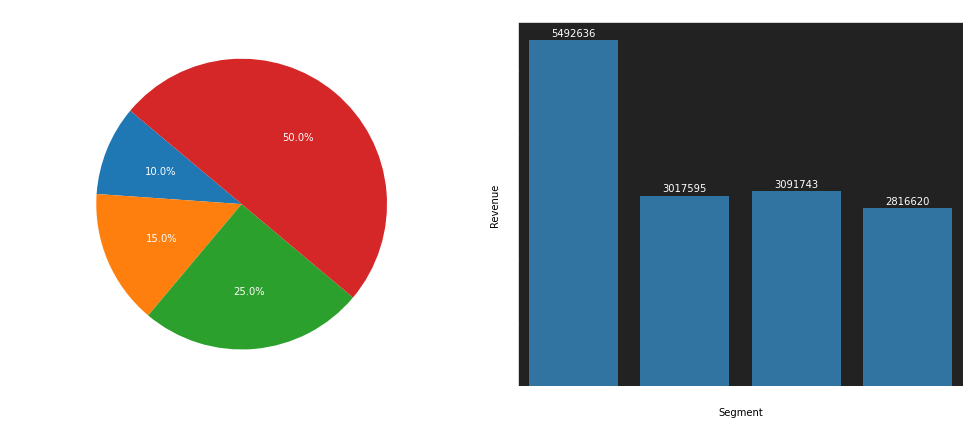

In [11]:
# Additional preprocessing and visualization
segment_counts = cust_rev['segment'].value_counts().reindex(['Top 10%', 'Top 25%', 'Top 50%', 'Lower 50%'])
seg_rev = cust_rev.groupby('segment')['total_revenue'].sum().reindex(['Top 10%', 'Top 25%', 'Top 50%', 'Lower 50%'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Pie Chart (left) ---
labels = [f"{segment} ({count:,})" for segment, count in zip(segment_counts.index, segment_counts.values)]
wedges, texts, autotexts = axes[0].pie(
    segment_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'color': 'white'}
)
axes[0].set_title('Customer Segment Distribution', color='white')

# --- Bar Chart (right) ---
sns.barplot(x=seg_rev.index, y=seg_rev.values, ax=axes[1])
axes[1].set_title('Revenue by Customer Segment', color='white')
axes[1].set_ylabel('Revenue')
axes[1].set_xlabel('Segment')

# Add value labels to bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.0f', label_type='edge', padding=2, color='white')

# Dark background styling
for ax in axes:
    ax.set_facecolor('#222222')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

plt.tight_layout()
plt.show()


### Seller Segment Analysis

In [12]:
# Determine the top 20% of sellers
print('20% of sellers equals the top',int(len(df['seller_id'].unique())*.2), 'of', len(df['seller_id'].unique()), 'sellers')

20% of sellers equals the top 617 of 3086 sellers


In [13]:
# Top 20% of sellers by revenue
top20pct_sellers = int(len(df['seller_id'].unique())*.2)
top_sellers = df.groupby('seller_id')['order_total_revenue'].sum().sort_values(ascending=False).head(top20pct_sellers)

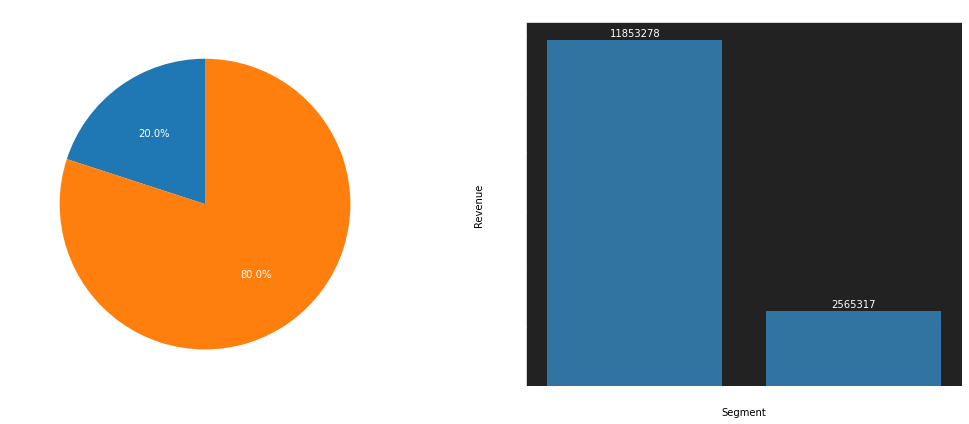

In [14]:
import seaborn as sns
# Filter original df to include only rows where seller_id is in top_sellers
top_seller_ids = top_sellers.index.tolist()
df_top_sellers = df[df['seller_id'].isin(top_seller_ids)]

# Create a new column categorizing seller type
df['seller_type'] = df['seller_id'].apply(lambda x: 'top20% sellers' if x in top_seller_ids else 'bottom80% sellers')

# Prepare data
# segment_counts = df['seller_type'].value_counts().reindex(['Top20% Seller', 'Bottom80% Seller'])
segment_counts = df[['seller_id', 'seller_type']].drop_duplicates()['seller_type'] \
    .value_counts().reindex(['top20% sellers', 'bottom80% sellers'])

seg_rev = df.groupby('seller_type')['item_revenue'].sum().reindex(['top20% sellers', 'bottom80% sellers'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Pie Chart (left) ---
labels = [f"{segment} ({count:,})" for segment, count in zip(segment_counts.index, segment_counts.values)]
wedges, texts, autotexts = axes[0].pie(
    segment_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'color': 'white'}
)
axes[0].set_title('Segment Distribution', color='white')

# --- Bar Chart (right) ---
sns.barplot(x=seg_rev.index, y=seg_rev.values, ax=axes[1])
axes[1].set_title('Revenue by Segment', color='white')
axes[1].set_ylabel('Revenue')
axes[1].set_xlabel('Segment')
from matplotlib.ticker import FuncFormatter

# Format y-axis to show in millions (e.g., 12M instead of 12000000)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Add value labels to bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.0f', label_type='edge', padding=2, color='white')

# Optional: Dark background styling
for ax in axes:
    ax.set_facecolor('#222222')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

plt.tight_layout()
plt.show()


In [15]:
top20revenuepct = (top_sellers.sum()/df.order_total_revenue.sum())*100
print(f'Top 20% of sellers make up {top20revenuepct:.1f}% of total revenue')

Top 20% of sellers make up 82.0% of total revenue


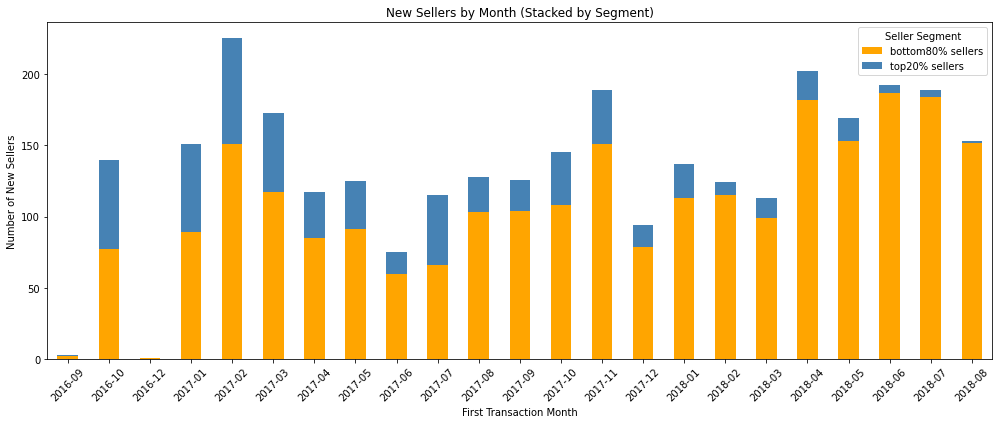

In [16]:
# Visual: New Sellers by Month

# Get first transaction per seller
seller_first_order = df.groupby('seller_id')['order_purchase_timestamp'].min().reset_index()
seller_first_order['first_order_month'] = pd.to_datetime(seller_first_order['order_purchase_timestamp']).dt.to_period('M').astype(str)

# Merge with seller type labels (Top 20% vs Bottom 80%)
seller_first_order = seller_first_order.merge(
    df[['seller_id', 'seller_type']].drop_duplicates(),
    on='seller_id',
    how='left'
)

# Count sellers per month per segment
seller_counts = seller_first_order.groupby(['first_order_month', 'seller_type']).size().unstack(fill_value=0)

# Sort by month
seller_counts = seller_counts.sort_index()

# Plot stacked bar chart
seller_counts.plot(kind='bar', stacked=True, figsize=(14, 6), color=['orange', 'steelblue'])

plt.title('New Sellers by Month (Stacked by Segment)')
plt.xlabel('First Transaction Month')
plt.ylabel('Number of New Sellers')
plt.xticks(rotation=45)
plt.legend(title='Seller Segment')
plt.tight_layout()
plt.show()


/var/folders/vf/pmvn9mq15916sb7pphmbx3_c0000gn/T/ipykernel_69136/653774227.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


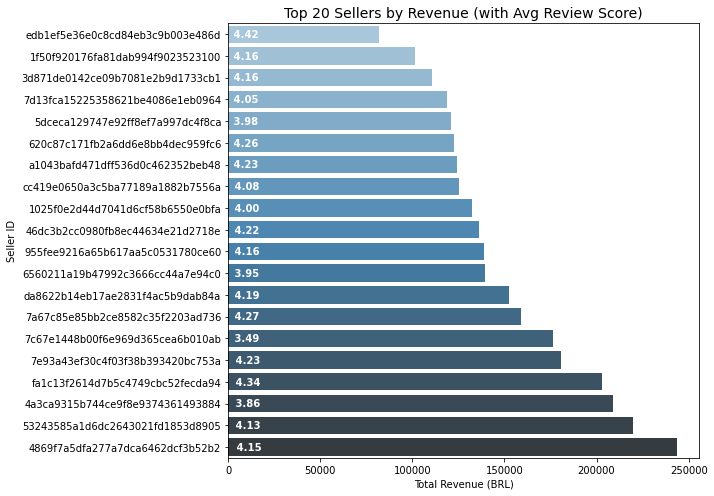

In [17]:
# Visual: Top 20 Sellers by Revenue and Their Avg Review Score

# Group by seller and calculate total revenue and avg review score
seller_summary = df.groupby('seller_id').agg({
    'item_revenue': 'sum',
    'review_score': 'mean'
}).reset_index()

# Get top 20 sellers by revenue
top20 = seller_summary.sort_values(by='item_revenue', ascending=False).head(20)

# Sort for prettier plot (ascending for horizontal bars)
top20 = top20.sort_values(by='item_revenue')

# Sort data
top20_sorted = top20.sort_values(by='item_revenue')

# Plot
plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=top20_sorted,
    y='seller_id',
    x='item_revenue',
    palette='Blues_d'
)

# Annotate review scores
for idx, row in enumerate(top20_sorted.itertuples()):
    ax.text(
        x=row.item_revenue * 0.01,
        y=idx,
        s=f" {row.review_score:.2f}",
        color='white',
        va='center',
        ha='left',
        fontsize=10,
        fontweight='bold'
    )

# Titles
ax.set_title('Top 20 Sellers by Revenue (with Avg Review Score)', fontsize=14)
ax.set_xlabel('Total Revenue (BRL)')
ax.set_ylabel('Seller ID')

plt.tight_layout()
plt.show()


<AxesSubplot: >

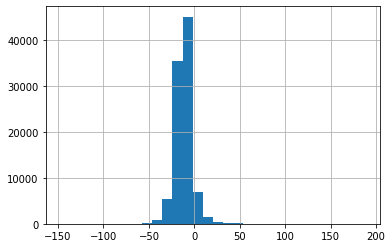

In [18]:
# Delivery delay distribution
df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df['delivery_delay'].hist(bins=30)

### 🧮 Customer Revenue Percentile by Seller

To better understand each customer's contribution to a seller's revenue, we calculate the revenue percentile for every customer within each seller's portfolio.

This provides a normalized view of customer importance — useful for prioritizing high-value buyers, building loyalty strategies, or optimizing marketing efforts.


In [19]:
# Preprocessing customer revenue segments
cust_rev = df.groupby('cust_unique_id')['item_revenue'].sum().reset_index()
cust_rev.columns = ['cust_unique_id', 'total_revenue']

cust_rev['revenue_percentile'] = cust_rev['total_revenue'].rank(pct=True) * 100

def revenue_bucket(p):
    if p >= 90:
        return 'Top 10%'
    elif p >= 75:
        return 'Top 25%'
    elif p >= 50:
        return 'Top 50%'
    else:
        return 'Lower 50%'

cust_rev['segment'] = cust_rev['revenue_percentile'].apply(revenue_bucket)
df = df.merge(cust_rev, on='cust_unique_id', how='left')

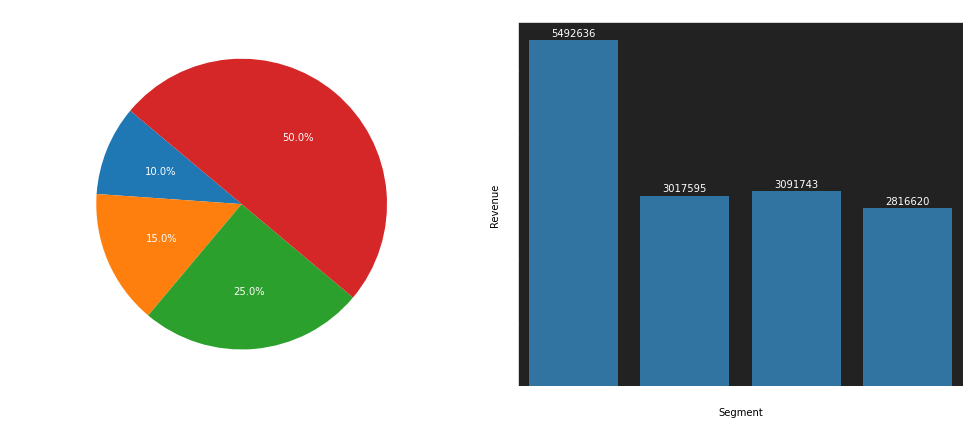

In [20]:
# Additional preprocessing and visualization
segment_counts = cust_rev['segment'].value_counts().reindex(['Top 10%', 'Top 25%', 'Top 50%', 'Lower 50%'])
seg_rev = cust_rev.groupby('segment')['total_revenue'].sum().reindex(['Top 10%', 'Top 25%', 'Top 50%', 'Lower 50%'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Pie Chart (left) ---
labels = [f"{segment} ({count:,})" for segment, count in zip(segment_counts.index, segment_counts.values)]
wedges, texts, autotexts = axes[0].pie(
    segment_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'color': 'white'}
)
axes[0].set_title('Customer Segment Distribution', color='white')

# --- Bar Chart (right) ---
sns.barplot(x=seg_rev.index, y=seg_rev.values, ax=axes[1])
axes[1].set_title('Revenue by Customer Segment', color='white')
axes[1].set_ylabel('Revenue')
axes[1].set_xlabel('Segment')

# Add value labels to bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.0f', label_type='edge', padding=2, color='white')

# Optional: Dark background styling (if needed)
for ax in axes:
    ax.set_facecolor('#222222')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

plt.tight_layout()
plt.show()

Text(54.29469712848459, 70.00048629925172, 'top 49.3% of customers generate 80% of revenue')

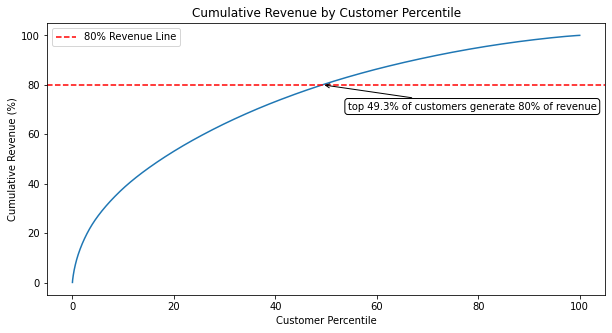

In [21]:
# Aggregate total revenue by customer
cust_revenue = df.groupby('cust_unique_id')['item_revenue'].sum().reset_index()

# Sort descending by revenue
cust_revenue = cust_revenue.sort_values(by='item_revenue', ascending=False)

# Calculate cumulative revenue
cust_revenue['cumulative_revenue'] = cust_revenue['item_revenue'].cumsum()
cust_revenue['cumulative_pct'] = cust_revenue['cumulative_revenue'] / cust_revenue['item_revenue'].sum() * 100

# Rank customer percentile
cust_revenue['customer_rank'] = range(1, len(cust_revenue) + 1)
cust_revenue['customer_pct'] = cust_revenue['customer_rank'] / len(cust_revenue) * 100


# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='customer_pct', y='cumulative_pct', data=cust_revenue)
plt.title('Cumulative Revenue by Customer Percentile')
plt.xlabel('Customer Percentile')
plt.ylabel('Cumulative Revenue (%)')
plt.axhline(80, color='red', linestyle='--', label='80% Revenue Line')
plt.legend()

# Find the point where cumulative revenue crosses 80%
cutoff_row = cust_revenue[cust_revenue['cumulative_pct'] >= 80].iloc[0]
x_val = cutoff_row['customer_pct']
y_val = cutoff_row['cumulative_pct']

# Annotate that point
plt.annotate(f"top {x_val:.1f}% of customers generate 80% of revenue",
             xy=(x_val, y_val), 
             xytext=(x_val + 5, y_val - 10),
             arrowprops=dict(arrowstyle='->', color='black'),
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=1),
             fontsize=10)


Text(22.91963707064161, 70.03190220564545, 'top 17.9% of sellers generate 80% of revenue')

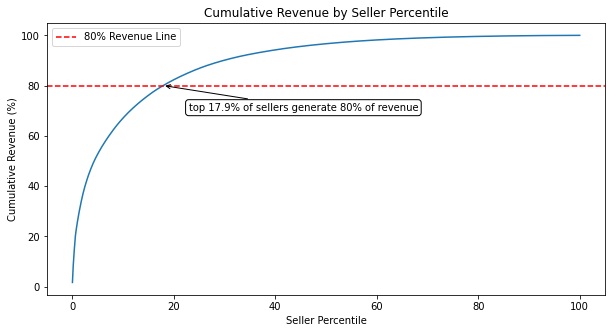

In [22]:
# Aggregate total revenue by seller
seller_revenue = df.groupby('seller_id')['item_revenue'].sum().reset_index()

# Sort descending by revenue
seller_revenue = seller_revenue.sort_values(by='item_revenue', ascending=False)

# Calculate cumulative revenue
seller_revenue['cumulative_revenue'] = seller_revenue['item_revenue'].cumsum()
seller_revenue['cumulative_pct'] = seller_revenue['cumulative_revenue'] / seller_revenue['item_revenue'].sum() * 100

# Rank seller percentile
seller_revenue['seller_rank'] = range(1, len(seller_revenue) + 1)
seller_revenue['seller_pct'] = seller_revenue['seller_rank'] / len(seller_revenue) * 100


# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='seller_pct', y='cumulative_pct', data=seller_revenue)
plt.title('Cumulative Revenue by Seller Percentile')
plt.xlabel('Seller Percentile')
plt.ylabel('Cumulative Revenue (%)')
plt.axhline(80, color='red', linestyle='--', label='80% Revenue Line')
plt.legend()

# Find the point where cumulative revenue crosses 80%
cutoff_row = seller_revenue[seller_revenue['cumulative_pct'] >= 80].iloc[0]
x_val = cutoff_row['seller_pct']
y_val = cutoff_row['cumulative_pct']

# Annotate that point
plt.annotate(f"top {x_val:.1f}% of sellers generate 80% of revenue",
             xy=(x_val, y_val), 
             xytext=(x_val + 5, y_val - 10),
             arrowprops=dict(arrowstyle='->', color='black'),
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=1),
             fontsize=10)


In [23]:
# Get the first purchase month for each customer
df['cohort_month'] = df.groupby('cust_unique_id')['order_purchase_timestamp']\
    .transform('min').dt.to_period('M')


In [24]:
from operator import attrgetter

# Current order month
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')

# Calculate months since first purchase
df['cohort_index'] = (df['order_month'] - df['cohort_month']).apply(attrgetter('n'))


In [25]:
# Group by cohort and cohort_index
cohort_data = df.groupby(['cohort_month', 'cohort_index'])['item_revenue'].sum().reset_index()

# Pivot the table
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='item_revenue')


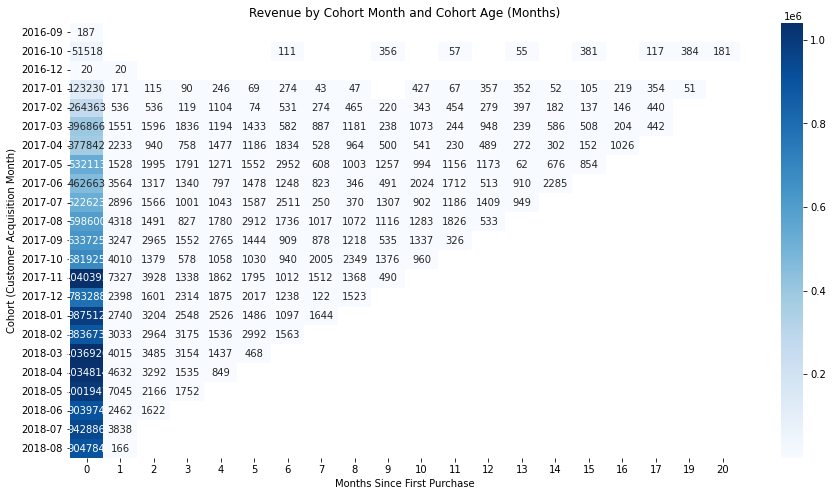

In [26]:
import seaborn as sns
plt.figure(figsize=(15, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Revenue by Cohort Month and Cohort Age (Months)')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort (Customer Acquisition Month)')
plt.show()


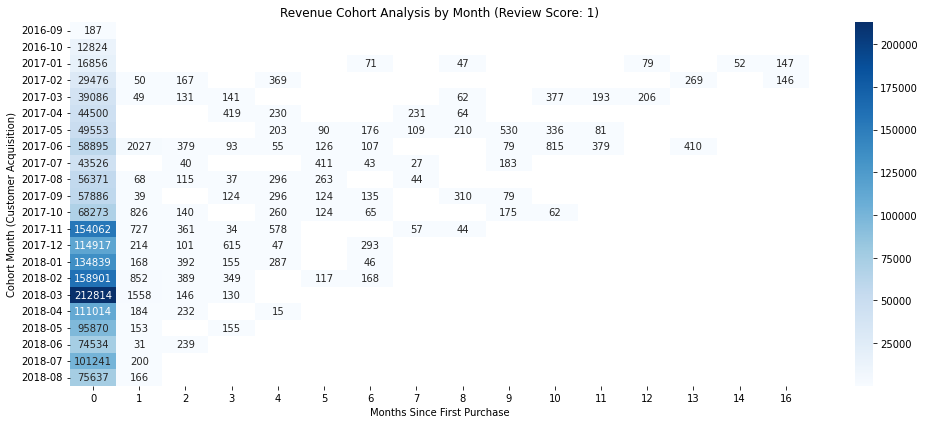

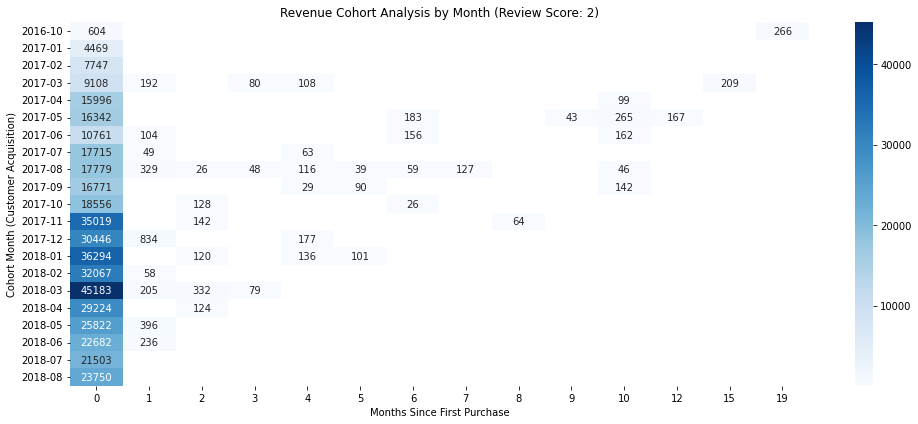

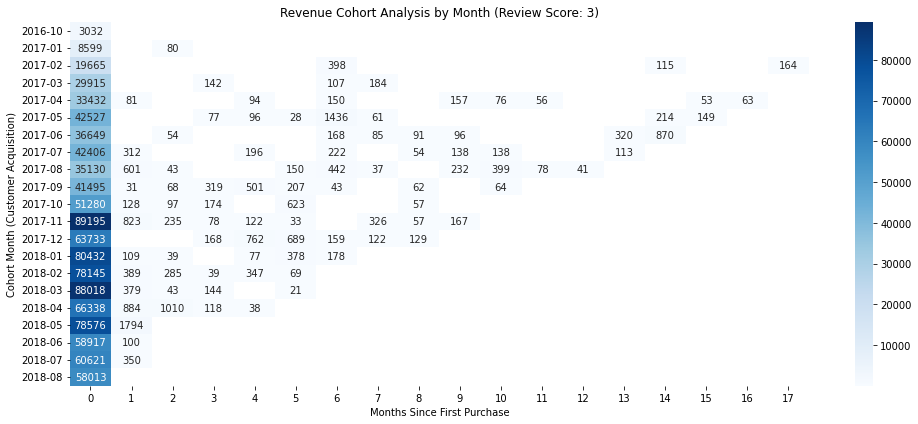

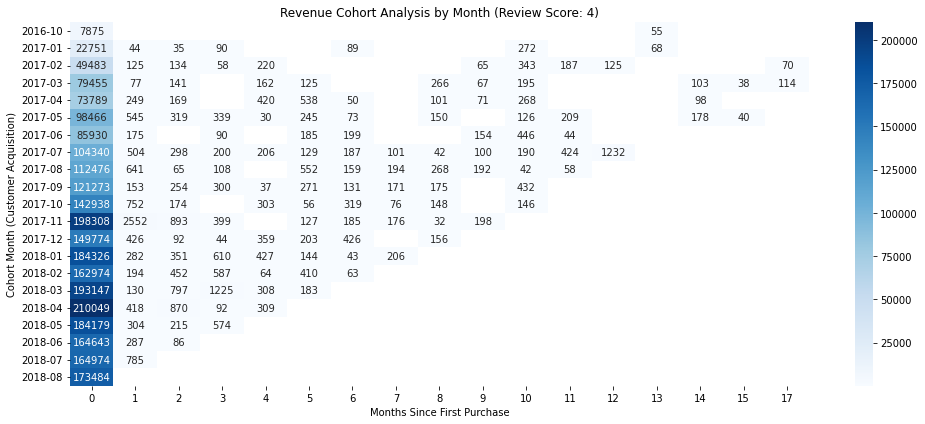

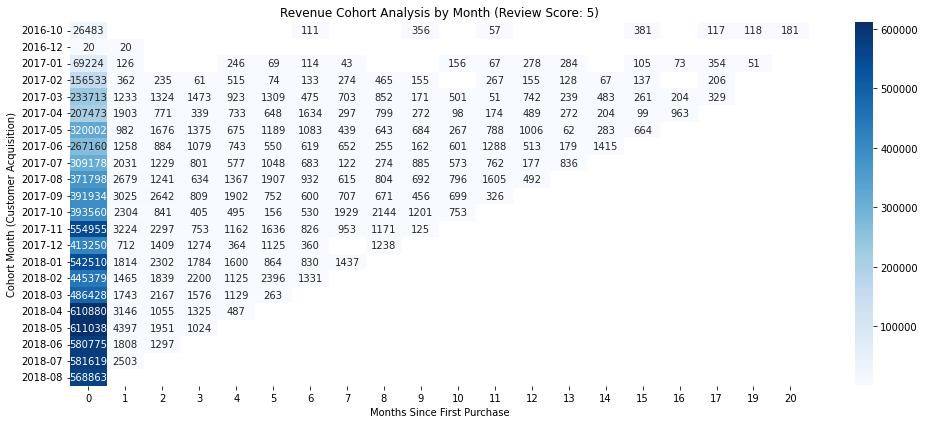

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'order_month', 'cohort_month', and 'cohort_index' are already in df

# Group by cohort fields and review score
cohort_by_score = df.groupby(
    ['cohort_month', 'cohort_index', 'review_score']
)['item_revenue'].sum().reset_index()

# Loop through review scores to plot individual heatmaps
for score in sorted(df['review_score'].dropna().unique()):
    subset = cohort_by_score[cohort_by_score['review_score'] == score]

    # Pivot for heatmap
    cohort_pivot = subset.pivot(index='cohort_month', columns='cohort_index', values='item_revenue')

    # Plot
    plt.figure(figsize=(14, 6))
    sns.heatmap(cohort_pivot, cmap='Blues', annot=True, fmt='.0f')
    plt.title(f'Revenue Cohort Analysis by Month (Review Score: {int(score)})')
    plt.xlabel('Months Since First Purchase')
    plt.ylabel('Cohort Month (Customer Acquisition)')
    plt.tight_layout()
    plt.show()


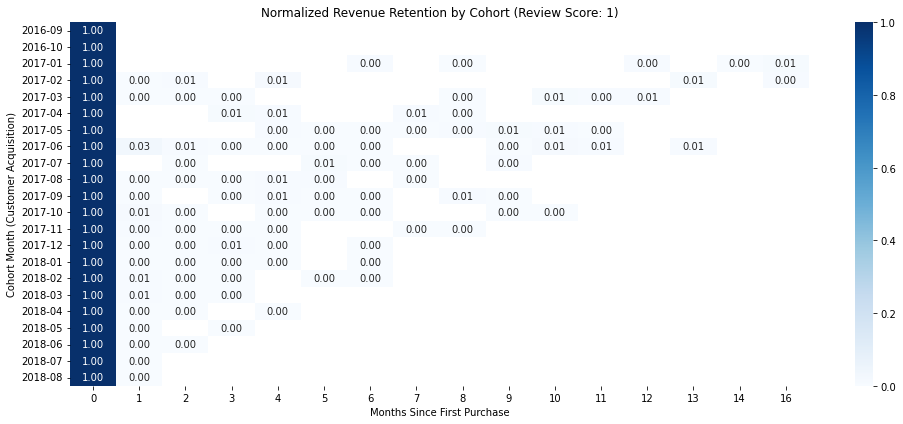

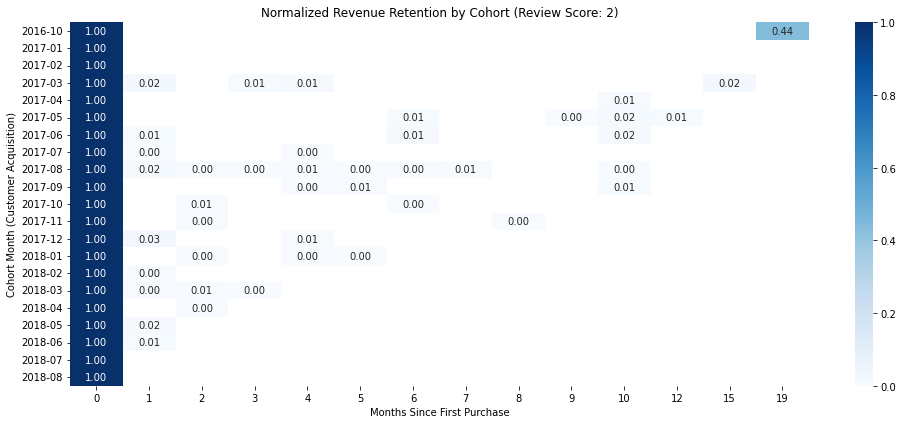

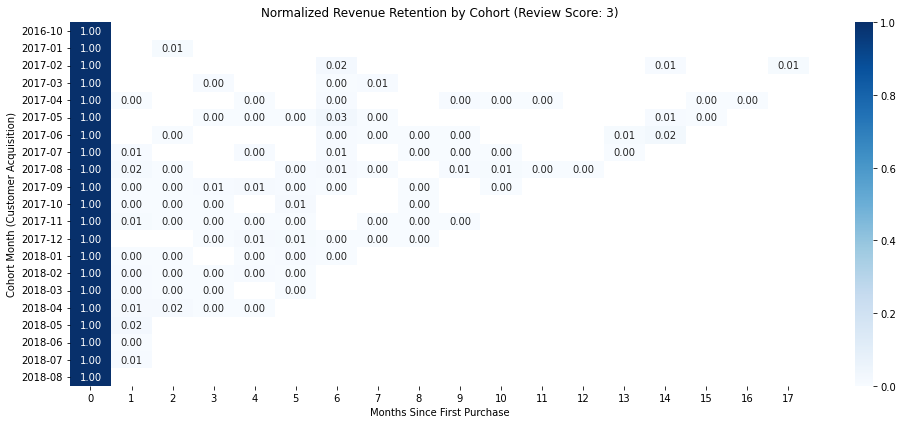

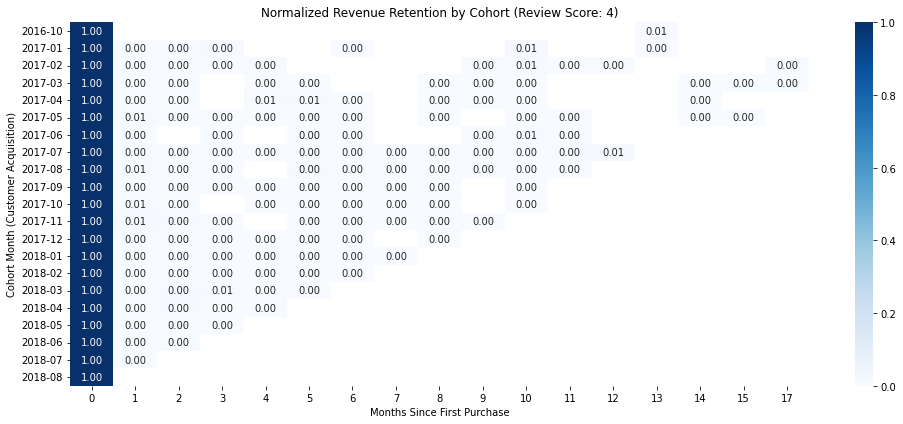

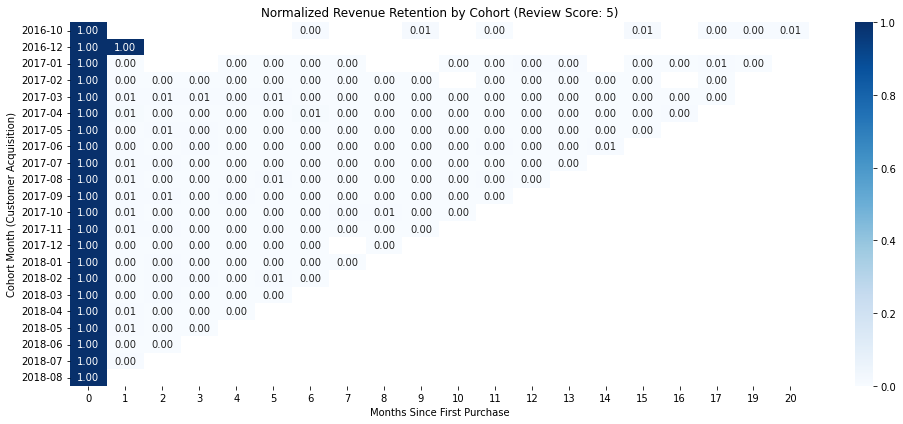

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group revenue
cohort_by_score = df.groupby(
    ['cohort_month', 'cohort_index', 'review_score']
)['item_revenue'].sum().reset_index()

# Step 2: Loop through each review score and normalize
for score in sorted(df['review_score'].dropna().unique()):
    subset = cohort_by_score[cohort_by_score['review_score'] == score]

    # Pivot to wide format
    cohort_pivot = subset.pivot(index='cohort_month', columns='cohort_index', values='item_revenue')

    # Step 3: Normalize by month 0 revenue
    cohort_norm = cohort_pivot.divide(cohort_pivot[0], axis=0)

    # Step 4: Plot
    plt.figure(figsize=(14, 6))
    sns.heatmap(cohort_norm, cmap='Blues', annot=True, fmt='.2f', vmin=0, vmax=1)
    plt.title(f'Normalized Revenue Retention by Cohort (Review Score: {int(score)})')
    plt.xlabel('Months Since First Purchase')
    plt.ylabel('Cohort Month (Customer Acquisition)')
    plt.tight_layout()
    plt.show()


> ⚠️ **Cohort Analysis Insight**  
> The cohort analysis suggests that `cust_unique_id` may not reliably track returning users. Even satisfied customers rarely appear in subsequent periods, which raises concerns that returning buyers may be assigned new IDs.  
> This data limitation impacts any metric relying on customer retention (e.g., churn, LTV) and should be considered when interpreting results.


In [29]:
# Flag only late deliveries
df['late_delivery'] = df['delivery_delay'] > 0

# Preview late deliveries
df[df['late_delivery']].head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,...,segment_x,seller_type,delivery_delay,total_revenue_y,revenue_percentile_y,segment_y,cohort_month,order_month,cohort_index,late_delivery
20,000e906b789b55f64edcb1f84030f90d,6a3b2fc9f270df258605e22bef19fd88,delivered,2017-11-21 18:54:23,2017-12-09 17:27:23,2017-12-07,57d79905de06d8897872c551bfd09358,ea8482cd71df3c1969d7b9473ff13abc,21.99,11.85,...,Lower 50%,top20% sellers,2.0,33.840000,6.635925,Lower 50%,2017-11,2017-11,0,True
36,0017afd5076e074a48f1f1a4c7bac9c5,8085a9af46f619bc25966f151a362b0d,delivered,2017-04-06 22:16:10,2017-05-23 08:32:07,2017-05-19,fe59a1e006df3ac42bf0ceb876d70969,25c5c91f63607446a97b143d2d535d31,809.10,44.29,...,Top 10%,top20% sellers,4.0,997.959976,98.966674,Top 10%,2017-04,2017-04,0,True
42,001c85b5f68d2be0cb0797afc9e8ce9a,48ed31e735f1c420ed6ca3637b7c744d,delivered,2017-11-24 19:19:18,2017-12-22 18:37:40,2017-12-14,84f456958365164420cfc80fbe4c7fab,4a3ca9315b744ce9f8e9374361493884,99.00,13.71,...,Top 50%,top20% sellers,8.0,112.710000,56.238734,Top 50%,2017-11,2017-11,0,True
43,001d8f0e34a38c37f7dba2a37d4eba8b,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-26 13:14:50,2017-05-24,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,18.99,7.78,...,Lower 50%,bottom80% sellers,2.0,26.770000,2.462272,Lower 50%,2017-05,2017-05,0,True
74,0030d783f979fbc5981e75613b057344,84ddc138522822dfb51b603c2f466a18,delivered,2017-11-24 20:03:02,2018-01-06 00:25:43,2017-12-15,ae27a5524edb2c8dc4656c670f458fb7,8e6cc767478edae941d9bd9eb778d77a,60.60,17.67,...,Lower 50%,top20% sellers,22.0,78.269999,39.302557,Lower 50%,2017-11,2017-11,0,True


In [30]:
# Add severity level
def delay_bucket(d):
    if d <= 0:
        return 'Early or On Time'
    elif d <= 3:
        return 'Slight Delay'
    elif d <= 7:
        return 'Moderate Delay'
    else:
        return 'Severe Delay'

df['delivery_bucket'] = df['delivery_delay'].apply(delay_bucket)


In [31]:
# Check severity level was added correctly
df[df['late_delivery']].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,...,seller_type,delivery_delay,total_revenue_y,revenue_percentile_y,segment_y,cohort_month,order_month,cohort_index,late_delivery,delivery_bucket
20,000e906b789b55f64edcb1f84030f90d,6a3b2fc9f270df258605e22bef19fd88,delivered,2017-11-21 18:54:23,2017-12-09 17:27:23,2017-12-07,57d79905de06d8897872c551bfd09358,ea8482cd71df3c1969d7b9473ff13abc,21.99,11.85,...,top20% sellers,2.0,33.840000,6.635925,Lower 50%,2017-11,2017-11,0,True,Slight Delay
36,0017afd5076e074a48f1f1a4c7bac9c5,8085a9af46f619bc25966f151a362b0d,delivered,2017-04-06 22:16:10,2017-05-23 08:32:07,2017-05-19,fe59a1e006df3ac42bf0ceb876d70969,25c5c91f63607446a97b143d2d535d31,809.10,44.29,...,top20% sellers,4.0,997.959976,98.966674,Top 10%,2017-04,2017-04,0,True,Moderate Delay
42,001c85b5f68d2be0cb0797afc9e8ce9a,48ed31e735f1c420ed6ca3637b7c744d,delivered,2017-11-24 19:19:18,2017-12-22 18:37:40,2017-12-14,84f456958365164420cfc80fbe4c7fab,4a3ca9315b744ce9f8e9374361493884,99.00,13.71,...,top20% sellers,8.0,112.710000,56.238734,Top 50%,2017-11,2017-11,0,True,Severe Delay
43,001d8f0e34a38c37f7dba2a37d4eba8b,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-26 13:14:50,2017-05-24,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,18.99,7.78,...,bottom80% sellers,2.0,26.770000,2.462272,Lower 50%,2017-05,2017-05,0,True,Slight Delay
74,0030d783f979fbc5981e75613b057344,84ddc138522822dfb51b603c2f466a18,delivered,2017-11-24 20:03:02,2018-01-06 00:25:43,2017-12-15,ae27a5524edb2c8dc4656c670f458fb7,8e6cc767478edae941d9bd9eb778d77a,60.60,17.67,...,top20% sellers,22.0,78.269999,39.302557,Lower 50%,2017-11,2017-11,0,True,Severe Delay


/var/folders/vf/pmvn9mq15916sb7pphmbx3_c0000gn/T/ipykernel_69136/367945389.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='delivery_bucket', order=bucket_order, palette='Set2')


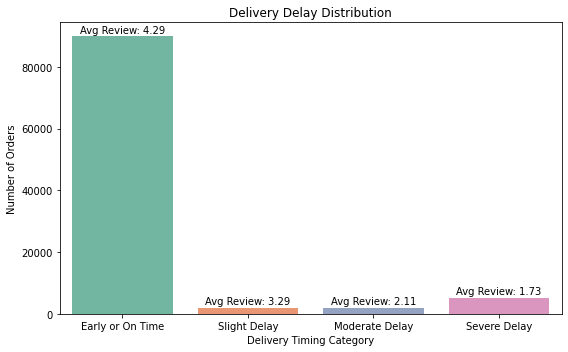

In [32]:
# Apply severity level with previously defined function
df['delivery_bucket'] = df['delivery_delay'].apply(delay_bucket)

# Calculate average review score per delivery bucket
avg_scores = df.groupby('delivery_bucket')['review_score'].mean()

# Define bucket order
bucket_order = ['Early or On Time', 'Slight Delay', 'Moderate Delay', 'Severe Delay']

# Plot: Delivery Delay Distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='delivery_bucket', order=bucket_order, palette='Set2')
plt.title('Delivery Delay Distribution')
plt.ylabel('Number of Orders')
plt.xlabel('Delivery Timing Category')
plt.xticks(rotation=0)

# Annotate bars with average review scores
for bar in ax.patches:
    bucket = bar.get_x() + bar.get_width() / 2
    label = bar.get_x() + bar.get_width() / 2
    height = bar.get_height()
    bucket_name = bar.get_x() + bar.get_width() / 2
    bucket_idx = int(bar.get_x() + bar.get_width() / 2)
    
    delivery_label = bar.get_label()  # not useful here, use order directly
    x_label = bar.get_x() + bar.get_width() / 2
    bucket_name = bar.get_x()
    
for bar, bucket in zip(ax.patches, bucket_order):
    height = bar.get_height()
    avg_score = avg_scores[bucket]
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 500,  # adjust this value if needed
        f"Avg Review: {avg_score:.2f}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.tight_layout()
plt.show()


- As expected Early or On Time deliveries score much higher reviews than late deliveries
- Average review ratings drop sharply as delivery delays increase — from 4.29 (on-time) to 1.73 (severe delays), highlighting the strong link between fulfillment performance and customer satisfaction.

In [33]:
# Pre-processing for visualization
monthly_ontime = df.groupby('order_month').agg({
    'item_revenue': 'sum',
    'late_delivery': 'mean'
}).reset_index()

monthly_ontime['pct_ontime'] = (1 - monthly_ontime['late_delivery']) * 100

monthly_ontime['order_month'] = monthly_ontime['order_month'].astype(str)


In [34]:
# Check dataframe is setup correctly
monthly_ontime.head()

,order_month,item_revenue,late_delivery,pct_ontime
0,2016-09,187.450004,0.333333,66.666667
1,2016-10,51518.229781,0.006494,99.350649
2,2016-12,19.620000,0.000000,100.000000
3,2017-01,123249.519885,0.027883,97.211660
4,2017-02,264533.799887,0.028275,97.172533


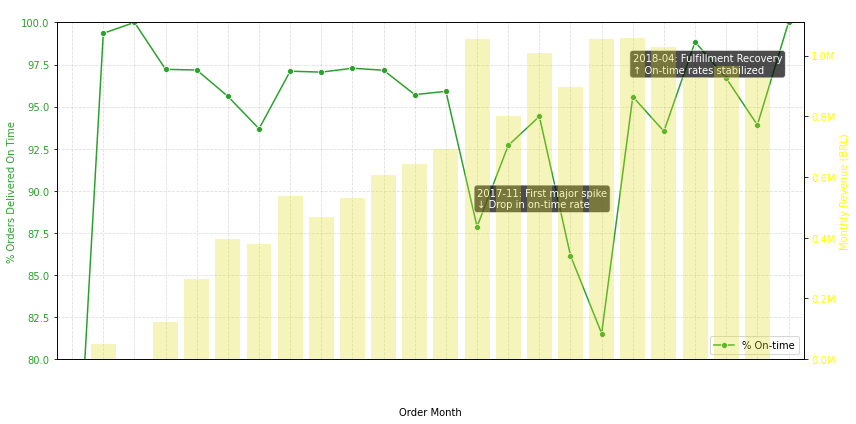

In [35]:
import matplotlib.ticker as mtick

# 📊 Combo Chart: Monthly Revenue vs % On-Time Deliveries

# Create the base figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# ➤ Lineplot: % Orders Delivered On Time
sns.lineplot(
    data=monthly_ontime,
    x='order_month',
    y='pct_ontime',
    marker='o',
    ax=ax1,
    color='tab:green',
    label='% On-time'
)
ax1.set_ylabel('% Orders Delivered On Time', color='tab:green')
ax1.set_ylim(80, 100)
ax1.set_xlabel('Order Month')
ax1.tick_params(axis='y', labelcolor='tab:green')
ax1.tick_params(axis='x', colors='white')  # adjust for dark background if used
ax1.set_title('Monthly Delivery Performance vs Revenue', color='white')
ax1.grid(True, linestyle='--', alpha=0.4)

# Rotate x-axis labels for readability
for label in ax1.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

# ➤ Secondary Axis: Monthly Revenue (Bar Chart)
ax2 = ax1.twinx()
sns.barplot(
    data=monthly_ontime,
    x='order_month',
    y='item_revenue',
    ax=ax2,
    alpha=0.3,
    color='yellow'
)
ax2.set_ylabel('Monthly Revenue (BRL)', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))

# ➤ Highlight + Annotate Events

# Locate 2017-11 and 2018-04 data points
highlight_2017 = monthly_ontime[monthly_ontime['order_month'] == '2017-11']
highlight_2018 = monthly_ontime[monthly_ontime['order_month'] == '2018-04']

# Annotate first disruption
ax1.annotate(
    '2017-11: First major spike\n↓ Drop in on-time rate',
    xy=(highlight_2017['order_month'].values[0], highlight_2017['pct_ontime'].values[0]),
    xytext=('2017-11', 89),
    textcoords='data',
    arrowprops=dict(arrowstyle='->', color='white'),
    color='white',
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', edgecolor='white', alpha=0.7)
)

# Annotate recovery point
ax1.annotate(
    '2018-04: Fulfillment Recovery\n↑ On-time rates stabilized',
    xy=(highlight_2018['order_month'].values[0], highlight_2018['pct_ontime'].values[0]),
    xytext=('2018-04', 97),
    textcoords='data',
    arrowprops=dict(arrowstyle='->', color='white'),
    color='white',
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', edgecolor='white', alpha=0.7)
)

# Final layout polish
fig.tight_layout()
plt.show()


📦 Fulfillment Performance vs Revenue Growth
Between November 2017 and March 2018, Olist experienced a sharp increase in monthly revenue, indicating rapid customer growth. However, during this same period, the percentage of orders delivered on time dropped significantly — falling to its lowest point in March 2018.

This trend suggests that the company likely struggled to fulfill the growing volume of orders, possibly due to limitations in their logistics or fulfillment capacity.

By April 2018, the company appears to have recovered, as on-time delivery rates rebounded while revenue remained high. This inflection point likely reflects internal improvements, such as:

- Scaling fulfillment operations

- Optimizing delivery logistics

- Expanding warehouse capacity or third-party delivery support

This pattern highlights the importance of aligning operational capacity with customer growth to avoid service disruptions during scale.

### ⚠️ Anomaly Detection

In [36]:
from scipy import stats

# Z-score of item revenue
df['z_item_revenue'] = stats.zscore(df['item_revenue'])

# Flag anomalies
df['revenue_anomaly'] = df['z_item_revenue'].abs() > 3
df[df['revenue_anomaly']].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,...,total_revenue_y,revenue_percentile_y,segment_y,cohort_month,order_month,cohort_index,late_delivery,delivery_bucket,z_item_revenue,revenue_anomaly
7,000576fe39319847cbb9d288c5617fa6,9ed5e522dd9dd85b4af4a077526d8117,delivered,2018-07-04 12:08:27,2018-07-09 14:04:07,2018-07-25,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,810.00,70.75,...,880.750000,98.686858,Top 10%,2018-07,2018-07,0,False,Early or On Time,3.701997,True
36,0017afd5076e074a48f1f1a4c7bac9c5,8085a9af46f619bc25966f151a362b0d,delivered,2017-04-06 22:16:10,2017-05-23 08:32:07,2017-05-19,fe59a1e006df3ac42bf0ceb876d70969,25c5c91f63607446a97b143d2d535d31,809.10,44.29,...,997.959976,98.966674,Top 10%,2017-04,2017-04,0,True,Moderate Delay,3.564120,True
290,00c9474e0334f7a4ffc8c3a8bd21a51e,e84d9c0fb40fccf1b0e326e840f6a8ec,delivered,2018-05-04 19:19:10,2018-05-16 22:56:45,2018-05-17,4b2653088591de362e6ba85b4a474c75,610f72e407cdd7caaa2f8167b0163fd8,1050.61,25.13,...,1075.739985,99.121777,Top 10%,2018-05,2018-05,0,False,Early or On Time,4.684625,True
308,00d2559e61b9a0744a0552c35c5ecccb,d4af02c83608285f0bd9ff891130c980,delivered,2018-06-11 12:24:48,2018-06-18 16:51:52,2018-06-28,44fc450365728c413fefc547592626be,b839e41795b7f3ad94cc2014a52f6796,849.00,23.52,...,872.520000,98.656466,Top 10%,2018-06,2018-06,0,False,Early or On Time,3.660523,True
420,011a43bc9bb525517251ebb3ebc99b69,bc6123686b421b9084028c34499824c4,delivered,2018-04-25 18:15:05,2018-04-30 15:48:24,2018-05-09,ca7966fa77959536468be3c6ce1f19e1,610f72e407cdd7caaa2f8167b0163fd8,899.00,21.20,...,920.200001,98.818906,Top 10%,2018-04,2018-04,0,False,Early or On Time,3.900801,True


In [37]:
anomalies = df[df['revenue_anomaly']]

# Summarize key columns for anomolies
anomalies[['price', 'freight_value', 'item_revenue']].describe()


,price,freight_value,item_revenue
count,1742.000000,1742.000000,1742.000000
mean,1184.535482,57.550224,1242.085708
std,591.713685,51.532660,602.010783
min,550.000000,12.460000,741.450000
25%,799.990000,24.427500,859.192497
50%,990.000000,38.540000,1039.820012
75%,1340.000000,69.695000,1391.350025
max,6735.000000,409.680000,6929.309998


In [38]:
# Summarize key columns for df
df[~df['revenue_anomaly']][['price', 'freight_value', 'item_revenue']].describe()

,price,freight_value,item_revenue
count,96924.000000,96924.000000,96924.000000
mean,106.914392,19.523654,126.438046
std,102.054428,13.535626,107.703342
min,0.850000,0.000000,9.090000
25%,40.000000,13.160000,56.780000
50%,77.900000,16.250000,94.300000
75%,134.990000,20.980000,158.109995
max,723.740000,299.160000,741.439999


In [39]:
df['anomaly_flag'] = df['revenue_anomaly'].map({True: 'Anomaly', False: 'Normal'})

/var/folders/vf/pmvn9mq15916sb7pphmbx3_c0000gn/T/ipykernel_69136/529967560.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='anomaly_flag', y='item_revenue', palette={'Anomaly': 'tomato', 'Normal': 'skyblue'})


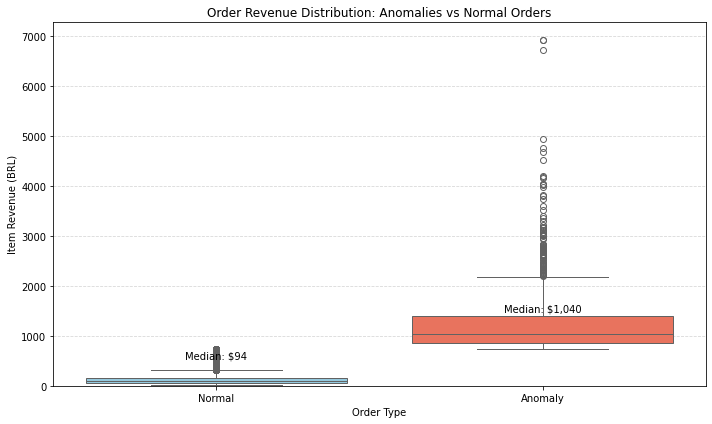

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='anomaly_flag', y='item_revenue', palette={'Anomaly': 'tomato', 'Normal': 'skyblue'})

# Calculate and annotate medians
medians = df.groupby('anomaly_flag')['item_revenue'].median()
for i, (label, median_val) in enumerate(medians.loc[['Normal', 'Anomaly']].items()):
    plt.text(i, median_val + 450, f'Median: ${median_val:,.0f}', 
             ha='center', color='black', fontsize=10)

plt.title('Order Revenue Distribution: Anomalies vs Normal Orders')
plt.ylabel('Item Revenue (BRL)')
plt.xlabel('Order Type')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, df['item_revenue'].max() * 1.05)  # optional: pad top of y-axis
plt.tight_layout()
plt.show()


##### 📦 Anomaly Detection: Order Revenue Impact
- ❌ High-value orders are more likely to be flagged as anomalies.
The median item revenue for anomalous orders is over 1,000 BRL, compared to just 94 BRL for normal orders.
- This suggests potential operational or fulfillment challenges in processing large orders, which may lead to delays, cancellations, or customer complaints.

##### 🧠 Business Risk Insight:
- If left unresolved, this pattern could mean the company is failing to capture or retain its highest-value transactions — a costly weakness in a competitive e-commerce environment.

21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:22 - cmdstanpy - INFO - Chain [1] done processing
/Users/joelam/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:23 - cmdstanpy - INFO - Chain [1] done processing
/Users/joelam/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


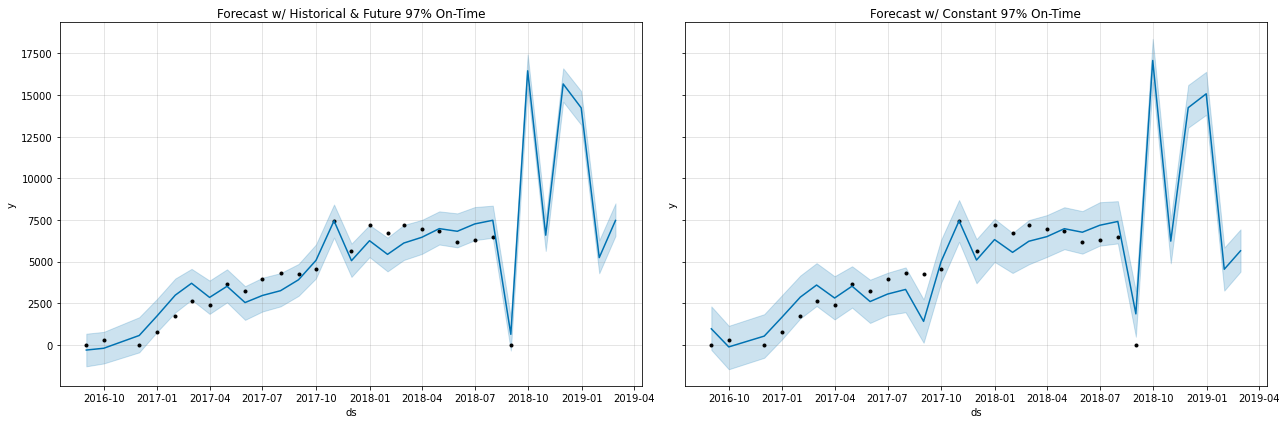

In [48]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare monthly data
df['order_month'] = pd.to_datetime(df['order_purchase_timestamp']).dt.to_period('M')
monthly_orders = df.groupby('order_month').size().reset_index(name='order_count')
monthly_reliability = df.groupby('order_month')['delivery_delay'].apply(lambda x: (x <= 0).mean()).reset_index(name='pct_ontime')

# Merge reliability into order volume
monthly_orders['ds'] = monthly_orders['order_month'].dt.to_timestamp()
monthly_orders.rename(columns={'order_count': 'y'}, inplace=True)
df_prophet = pd.merge(monthly_orders, monthly_reliability, on='order_month')

# SCENARIO 1: Actual + Future Projected (0.97)
df_scenario1 = df_prophet[['ds', 'y', 'pct_ontime']].rename(columns={'pct_ontime': 'regressor'})
model_1 = Prophet()
model_1.add_regressor('regressor')
model_1.fit(df_scenario1)

future_df_1 = model_1.make_future_dataframe(periods=6, freq='M')
future_df_1['regressor'] = pd.concat([df_scenario1['regressor'], pd.Series([0.97]*6)], ignore_index=True)
forecast_1 = model_1.predict(future_df_1)

# SCENARIO 2: All 0.97 On-Time
model_2 = Prophet()
model_2.add_regressor('regressor')
df_constant = df_prophet[['ds', 'y']].copy()
df_constant['regressor'] = 0.97
model_2.fit(df_constant)

future_df_2 = model_2.make_future_dataframe(periods=6, freq='M')
future_df_2['regressor'] = 0.97
forecast_2 = model_2.predict(future_df_2)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

model_1.plot(forecast_1, ax=axes[0])
axes[0].set_title("Forecast w/ Historical & Future 97% On-Time")

model_2.plot(forecast_2, ax=axes[1])
axes[1].set_title("Forecast w/ Constant 97% On-Time")

plt.tight_layout()
plt.show()

### ⛔ Forecasting Limitations

Prophet models were developed to explore future sales under different fulfillment scenarios (e.g., constant 97% on-time delivery vs. historical variability). However, the forecasts were ultimately excluded from the final analysis due to several limitations:

- 📉 **Overfitting**: The models captured one-off disruptions (e.g., 2018-09) as recurring seasonal trends, resulting in unrealistic future dips.
- 📆 **Limited historical data**: With under 24 months of reliable data, model generalization was weak, and trend detection was noisy.
- 🔍 **Domain misalignment**: The forecasts assumed fulfillment trends would continue, despite business context suggesting improvement and stabilization.

These issues reflect a core data science principle:  
> **"Just because you can model it, doesn’t mean you should."**

Forecasting was intentionally excluded to maintain the integrity and credibility of the analysis.
